# Analysis of DNA-MERFISH for CTP11,12,13

by Pu Zheng

2022.07.21

analysis for dataset:

* dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_7\20220713-P_brain_CTP11-13_from_0418'

* rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors'

## in mendel
* save_folder = r'F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418' 


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

26068


## 0.1 Folders

In [3]:
save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

analysis_folder = os.path.join(save_folder, 'Analysis_0709')

segmentation_folder = os.path.join(analysis_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(analysis_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")
    
picked_folder = os.path.join(analysis_folder, 'Picked_v0')
if not os.path.exists(picked_folder):
    os.makedirs(picked_folder)
    print(f"Creating picked_folder: {picked_folder}")
else:
    print(f"Use picked_folder: {picked_folder}")

161 fovs detected
Use segmentation_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Segmentation
Use cand_spot_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\CandSpots
Use decoder_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Decoder
Use picked_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Picked_v0


pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])

## Load Codebook

In [4]:
# load two codebooks
import pandas as pd

ctp11_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv', header=0)
ctp13_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-super-enhancers-1000_codebook.csv', header=0)
ctp13_codebook

,name,id,NDB_376,NDB_578,NDB_400,NDB_533,NDB_568,NDB_464,NDB_466,NDB_431,...,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,chr,chr_order
0,1:9600471-9656458,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:9749317-9845402,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,1:20888605-20953251,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,2
3,1:21475446-21564433,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
4,1:21674557-21793163,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,X:101910335-102015609,987,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,X,2
964,X:136772307-136851006,988,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,3
965,X:140481839-140547985,989,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,4
966,X:167122110-167191320,990,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,5


# Pick spots

In [5]:
weights = np.array([4,1,0])
num_libraries = 3
max_niter = 10
score_th = np.log(0.1)
_skip_picked = True
_overwrite_pick = False

In [21]:
import re
from tqdm import tqdm
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in os.listdir(decoder_folder) 
                     if re.search(r'Decoded_fov-(?P<fovId>[0-9]+)_cell-(?P<cellId>[0-9]+).hdf5', _fl) is not None
                    ]
# init
_pick_args = []
for _decoder_filename in tqdm(decoder_filenames):
    _match_info = re.search(r'Decoded_fov-(?P<fovId>[0-9]+)_cell-(?P<cellId>[0-9]+).hdf5', _decoder_filename)
    if _match_info is None:
        continue
    _fov_id, _cell_id = _match_info.groupdict()['fovId'], _match_info.groupdict()['cellId'] 
    _picked_filename = os.path.join(picked_folder, f"Picked_fov-{_fov_id}_cell-{_cell_id}.hdf5")
    if not os.path.exists(_picked_filename) or not _skip_picked:
        _pick_args.append(
            (_decoder_filename, _picked_filename, num_libraries, weights, score_th, max_niter, _overwrite_pick)
        ) 
print(len(_pick_args))

100%|███████████████████████████████████████████████████████████████████████████| 19289/19289 [00:22<00:00, 870.58it/s]

563


## test picking

In [7]:
_pick_args[0]

('\\\\10.245.74.158\\Chromatin_NAS_8\\Analyzed_data\\20220402-P_brain_CTP11-13_from_0329_warp\\Analysis_0709\\Decoder\\Decoded_fov-0_cell-12.hdf5',
 '\\\\10.245.74.158\\Chromatin_NAS_8\\Analyzed_data\\20220402-P_brain_CTP11-13_from_0329_warp\\Analysis_0709\\Picked_v0\\Picked_fov-0_cell-12.hdf5',
 3,
 array([4, 1, 0]),
 -2.3025850929940455,
 10,
 False)

In [8]:
## Test pick one
from ImageAnalysis3.classes.picker import batch_pick_spots, SpotPicker
reload(ia.classes.picker)

sel_cell = 0
batch_pick_spots(*_pick_args[sel_cell])

- Load picker from file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Picked_v0\Picked_fov-0_cell-12.hdf5
-- savefile:\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Picked_v0\Picked_fov-0_cell-12.hdf5 not exist, skip
- Read savefile to load codebooks and coordinates
-- load combo of CTP11
-- load unique of CTP12tss
-- load combo of CTP13
- Merge codebooks and coordinates
5964 candidate cooridnates for 1984 regions in total. 


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 0 in 3.853s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 1 in 3.746s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 2 in 2.739s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 3 in 2.222s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 4 in 1.566s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 5 in 1.597s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 6 in 1.52

E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['name', 'id', 'chr', 'library', 'dtype'], dtype='object')]

  pytables.to_hdf(


In [9]:
_decoder_fl = _pick_args[sel_cell][0]
_ctp11_df = pd.read_hdf(_decoder_fl, 'CTP11/spotGroups')
_ctp12_df = pd.read_hdf(_decoder_fl, 'CTP12tss/candSpots')
_ctp13_df = pd.read_hdf(_decoder_fl, 'CTP11/spotGroups')


In [10]:
reload(ia.classes.picker)
from ImageAnalysis3.classes.picker import batch_pick_spots, SpotPicker

_picker = SpotPicker(_decoder_fl)
_picker._load_decoded()
_picker._merge_decoded()

- Load picker from file: None
saveFile not given, skip loading!
- Read savefile to load codebooks and coordinates
-- load combo of CTP11
-- load unique of CTP12tss
-- load combo of CTP13
- Merge codebooks and coordinates
5964 candidate cooridnates for 1984 regions in total. 


In [197]:
prepare_score_metrics(_picker)

In [199]:
_picker._generate_default_chr_copyNum()
_picker._init_homolog_centers()

E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [200]:
_picker.chr_2_homolog_centers['1']

array([[ 3241.39769298,  2409.30193287, 43625.57776579],
       [ 1233.10085817,  1883.8529748 , 42293.3898384 ]])

In [192]:
default_score_metric_names = ['center_intensity',
                              'center_internal_dist',
                              'homolog_center_dist',
                              'upstream_index',
                              'upstream_gdist',
                              'upstream_dist',
                             ]
def prepare_score_metrics(self, metric_names=default_score_metric_names):
    for _name in metric_names:
        if _name in self.merged_coords.columns:
            continue
        else:
            if self.verbose:
                print(f"col:{_name}")
            self.merged_coords.loc[:,_name] = np.nan
        
        
    

In [181]:
_picker.merged_coords.columns

Index(['region_name', 'chr', 'start', 'end', 'center_z', 'center_x',
       'center_y', 'center_intensity', 'center_internal_dist', 'codebook_name',
       'data_type', 'index', 'chr_order'],
      dtype='object')

In [135]:
Axis3D_infos = ['z', 'x', 'y']

<IPython.core.display.Javascript object>


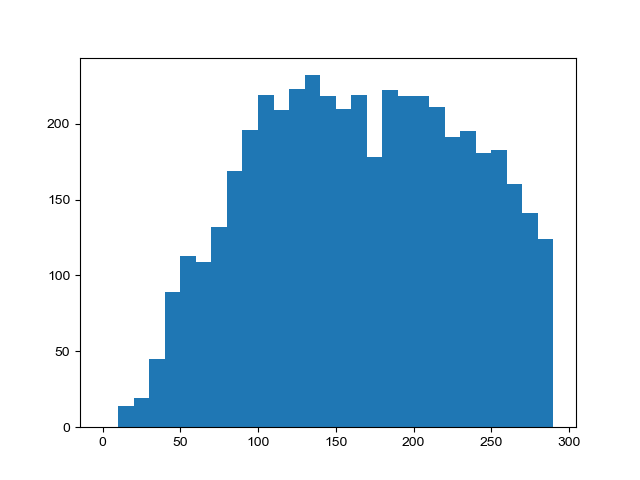

(array([  0.,  14.,  19.,  45.,  89., 113., 109., 132., 169., 196., 219.,
        209., 223., 232., 218., 210., 219., 178., 222., 218., 218., 211.,
        191., 195., 181., 183., 160., 141., 124.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290]),
 <BarContainer object of 29 artists>)

In [16]:
plt.figure()
plt.hist(_picker.merged_coords['center_internal_dist'], bins=np.arange(0,300,10))

## Visualize picked structures

In [11]:
from ImageAnalysis3.figure_tools.plot_decode import Centering_Chr2ZxysListDict
import matplotlib
plt.style.use('dark_background')
figure_width = 3
figure_dpi=100
_font_size = 7.5
background_color = [0,0,0]

# folder
picked_figure_folder = os.path.join(picked_folder, 'Figures')
if not os.path.exists(picked_figure_folder):
    os.makedirs(picked_figure_folder)
    print(f"Creating picked_figure_folder: {picked_figure_folder}")
else:
    print(f"Use picked_figure_folder: {picked_figure_folder}")

Creating picked_figure_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Picked_v0\Figures


<IPython.core.display.Javascript object>


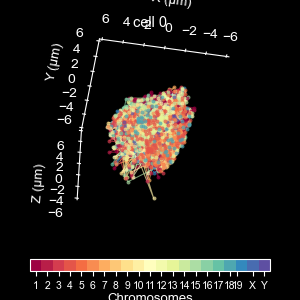

In [12]:
# select cell

from ImageAnalysis3.classes.picker import load_hdf5_dict
chr_2_zxys = {_chr:_hzxys[:,:,1:] 
              for _chr, _hzxys in load_hdf5_dict(_pick_args[sel_cell][1], 'picked/chr_2_filtered_hzxys_list').items()}

from ImageAnalysis3.structure_tools.distance import sort_human_chr
from matplotlib import animation
plot_animation = False
save_fig = False
angle = 3

_centered_dict = Centering_Chr2ZxysListDict(chr_2_zxys)
#_centered_dict = chr_2_zxys
plot_radius = 6

marker_size = 8
marker_alpha = 0.7
depthshade=False
cmap = copy.copy(cm.Spectral)
chr_2_color = {_key:cmap((sort_human_chr(_key)-1)/20) 
               for _key in sorted(chr_2_zxys.keys(), key = lambda v:sort_human_chr(v))}

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)

# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# scatter plot
for _chr in sorted(_centered_dict.keys(), key = lambda v:sort_human_chr(v)):

    _zxys_list = _centered_dict[_chr]/1000
    for _ihomo, _zxys in enumerate(_zxys_list):
        #print(_chr)
        _valid_inds = (np.isnan(_zxys).sum(1) == 0)
        _sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                           color=chr_2_color[_chr], 
                           s=marker_size, depthshade=depthshade, 
                           alpha=marker_alpha,
                           #edgecolors=_edge_colors, 
                           linewidth=0, label=f"{_chr}")
        _ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                        color=chr_2_color[_chr], linewidth=0.75, alpha=marker_alpha)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# title
ax3d.set_title(f"cell {sel_cell}" ,fontsize=_font_size+3, pad=0)
# colorbar
bounds = [sort_human_chr(_chr) for _chr in _centered_dict.keys()]
bounds.append(np.max(bounds)+1)
bounds = np.sort(bounds)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cbar_shrink = 0.8
m = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(m, ax=ax3d, orientation='horizontal', pad=0.1, 
                    ticks=bounds[:-1]+0.5,
                    boundaries=bounds,
                    shrink=cbar_shrink)
cbar.set_label('Chromosomes', fontsize=_font_size+2, labelpad=1,)
cbar.ax.set_xticklabels(list(sorted(_centered_dict.keys(), key = lambda v:sort_human_chr(v))), fontsize=_font_size)

# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(picked_figure_folder, 
                             f"{os.path.basename(_pick_args[sel_cell][1]).replace('.hdf5', '_picked.gif')}"), 
             writer=animation.PillowWriter(fps=30), )
elif save_fig:
    # save pdf and png
    fig.savefig(os.path.join(picked_figure_folder, 
                             f"{os.path.basename(_pick_args[sel_cell][1]).replace('.hdf5', '_picked.png')}"),
                transparent=True)
    fig.savefig(os.path.join(picked_figure_folder, 
                             f"{os.path.basename(_pick_args[sel_cell][1]).replace('.hdf5', '_picked.png')}"),
                transparent=True)
fig.show()

<IPython.core.display.Javascript object>


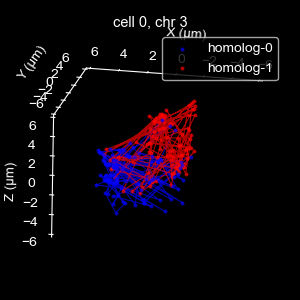

In [13]:
# Homologs
plt.style.use('dark_background')
plot_animation = False
angle = 3
plot_radius = 6
marker_size = 8
marker_alpha = 0.7
depthshade=False

chr_name = '3'

_zxys_list = _centered_dict[chr_name]/1000

cmap = copy.copy(cm.seismic)

homolog_2_color = {_i:cmap((_i+0.5)/(len(_zxys_list))) for _i in range(len(_zxys_list))}

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)

# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# scatter plot
for _ihomo, _zxys in enumerate(_zxys_list):
    #print(_chr)
    _valid_inds = (np.isnan(_zxys).sum(1) == 0)
    _sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                       color=homolog_2_color[_ihomo], 
                       s=marker_size, depthshade=depthshade, 
                       alpha=marker_alpha,
                       #edgecolors=_edge_colors, 
                       linewidth=0, label=f"homolog-{_ihomo}")
    _ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                    color=homolog_2_color[_ihomo], linewidth=0.75, alpha=marker_alpha)
    
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# title
ax3d.set_title(f"cell {sel_cell}, chr {chr_name}" ,fontsize=_font_size+3, pad=0)
# legend
ax3d.legend()
# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(picked_figure_folder, 
                             f"{os.path.basename(_pick_args[sel_cell][1]).replace('.hdf5', f'_chr{chr_name}_picked.gif')}"), 
             writer=animation.PillowWriter(fps=30), )
else:
    # save pdf and png
    fig.savefig(os.path.join(picked_figure_folder, 
                             f"{os.path.basename(_pick_args[sel_cell][1]).replace('.hdf5', f'_chr{chr_name}_picked.png')}"),
                transparent=True)
    fig.savefig(os.path.join(picked_figure_folder, 
                             f"{os.path.basename(_pick_args[sel_cell][1]).replace('.hdf5', f'_chr{chr_name}_picked.png')}"),
                transparent=True)
fig.show()

- Load picker from file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Picked_v0\Picked_fov-0_cell-12.hdf5
-- loading merged_codebook
-- loading merged_coords


<IPython.core.display.Javascript object>


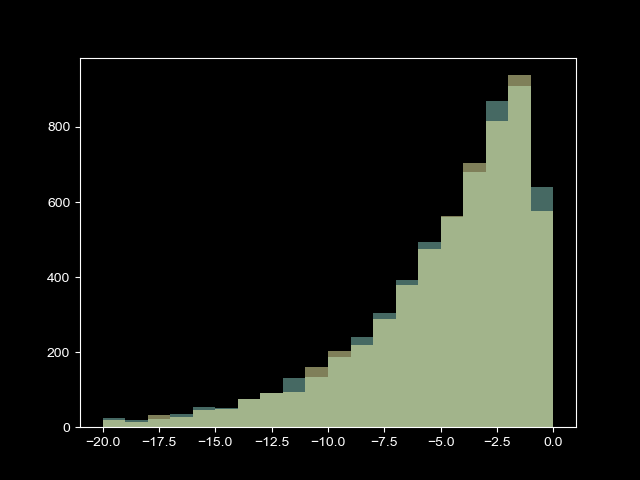

In [14]:
_picker = SpotPicker(_pick_args[sel_cell][0], save_file=_pick_args[sel_cell][1])
plt.figure()
plt.hist(_picker.merged_coords['score_h0'], bins=np.arange(-20,1),alpha=0.5)
plt.hist(_picker.merged_coords['score_h1'], bins=np.arange(-20,1),alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


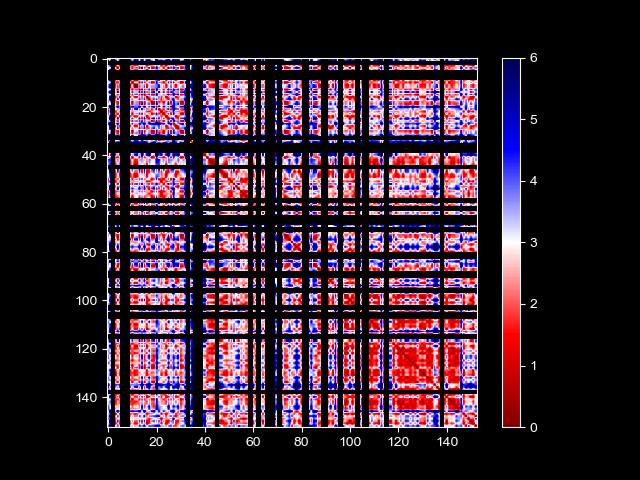

In [16]:
from scipy.spatial.distance import cdist,pdist, squareform
plt.figure()
plt.imshow(squareform(pdist(chr_2_zxys['1'][0][:,]))/1000, cmap='seismic_r', vmin=0, vmax=6)
plt.colorbar()
plt.show()

In [17]:
from ImageAnalysis3.classes.decode import DNA_Merfish_Decoder
merged_zxys_list = DNA_Merfish_Decoder.summarize_zxys_by_regions(chr_2_zxys, _picker.merged_codebook, keep_valid=True)

<IPython.core.display.Javascript object>


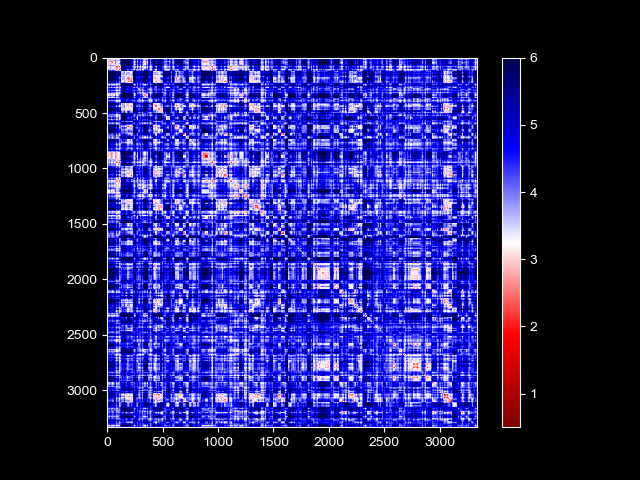

In [18]:
# if merge into single map:
merged_zxys = np.concatenate(merged_zxys_list)
merged_zxys = merged_zxys[(np.isnan(merged_zxys)==False).any(1)]

plt.figure()
plt.imshow(squareform(pdist(merged_zxys)), cmap='seismic_r', 
           vmin=0.5, vmax=6)
plt.colorbar()
plt.show()

# Batch pick spots

In [19]:
from ImageAnalysis3.classes.picker import batch_pick_spots
import multiprocessing as mp

In [22]:
%%time
print(len(_pick_args))
with mp.Pool(32) as pick_pool:
    pick_pool.starmap(batch_pick_spots, _pick_args, chunksize=1)
    pick_pool.close()
    pick_pool.join()
    pick_pool.terminate()

563
Wall time: 53.5 s


## pick sequentially

In [ ]:
%%time
for _args in _pick_args:
    batch_pick_spots(*_args)

In [ ]:
print('test')